<a href="https://colab.research.google.com/github/szhang12345/MSDS-422-Assignment-5-Principal-Components-Analysis-Clustering/blob/main/Assignment5_PCA_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MSDS 422 Assignment 5: PCA and Clustering**

**By Siying Zhang**

**Topic: Digit Recognizer**


# Ingest

In [9]:
# To support both python 2 and python 3
#Reference used for K-mean Cluster
#https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47
from __future__ import division, print_function, unicode_literals

# import base packages into the namespace for this program
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix

import time
import datetime
import os.path
# modeling routines from Scikit Learn packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import urllib.request as ur
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                                classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib # import matplotlib
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# Random number seed
seed = 42
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# read data
# DATA PREPARATION

# Download the data from an alternative source.
# mldata.org appears to be down (July 8, 2018)
#if not os.path.isfile('train.csv'):
#    ur.urlretrieve('https://pjreddie.com/media/files/mnist_train.csv',
#                   'train.csv')

#if not os.path.isfile('test.csv'):
#    ur.urlretrieve('https://pjreddie.com/media/files/mnist_test.csv',
 #                  'test.csv')




Reading Data

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
link = 'https://drive.google.com/file/d/1h_aqU6TrbBNKi-0FKO22J6UGzyNRWDTh/view?usp=sharing'

In [11]:
link2 = 'https://drive.google.com/file/d/1C_lcg3b1-ur5IRzNYFxXbfI8VZxurBUk/view?usp=sharing'

In [13]:
downloaded = drive.CreateFile({'id':'1C_lcg3b1-ur5IRzNYFxXbfI8VZxurBUk'}) 
downloaded.GetContentFile('mnist_train.csv')  
train = pd.read_csv('mnist_train.csv')

In [12]:
downloaded = drive.CreateFile({'id':'1h_aqU6TrbBNKi-0FKO22J6UGzyNRWDTh'}) 
downloaded.GetContentFile('mnist_test.csv')  
test = pd.read_csv('mnist_test.csv')

In [14]:
# Create arrays for use with sklearn
X_train = train.drop(['label'], axis=1).values
y_train = train['label'].values
X_test = test.drop(['label'], axis=1).values
y_test = test['label'].values

# EDA

In [15]:
# check the pandas DataFrame object training data
print('\nGeneral description of train set:')
print(train.info())

print('\nDescriptive statistics of train set:')
print(train.describe())


General description of train set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB
None

Descriptive statistics of train set:
              label      1x1      1x2  ...    28x26    28x27    28x28
count  60000.000000  60000.0  60000.0  ...  60000.0  60000.0  60000.0
mean       4.453933      0.0      0.0  ...      0.0      0.0      0.0
std        2.889270      0.0      0.0  ...      0.0      0.0      0.0
min        0.000000      0.0      0.0  ...      0.0      0.0      0.0
25%        2.000000      0.0      0.0  ...      0.0      0.0      0.0
50%        4.000000      0.0      0.0  ...      0.0      0.0      0.0
75%        7.000000      0.0      0.0  ...      0.0      0.0      0.0
max        9.000000      0.0      0.0  ...      0.0      0.0      0.0

[8 rows x 785 columns]


In [16]:
#test and train set shape
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


# Modeling

Dictionary for result tracking

In [17]:
# Initialize a dictionary to track results
metrics = {}

# Metrics for evaluation
names = ['F1 Score', 'Time', 'Number of Variables','Precision Score','Recall Score']


Modeling Selection

1. Random Forest Model 1 - All Variables

In [18]:
# Start timer for fit the model
start=datetime.datetime.now()

#Fit Random Forest Classifier - all variables
rf = RandomForestClassifier(n_estimators=784, max_features="sqrt", bootstrap=True, n_jobs=-1, random_state=seed)
rf.fit(X_train, y_train)

end=datetime.datetime.now()
duration = end-start

print(duration)

0:04:36.125338


In [19]:
#evaluation of model 1 on test set
y_test_rf = cross_val_predict(rf, X_test, y_test)
score=f1_score(y_test, y_test_rf, average="macro")
pre=precision_score(y_test, y_test_rf, average="macro")
rec=recall_score(y_test, y_test_rf, average="macro")
print(score)
print(precision_score(y_test, y_test_rf, average="macro"))
print(recall_score(y_test, y_test_rf, average="macro")) 

0.9487361740005626
0.9490832012144468
0.9485640299632584


In [20]:
metrics['RF - No PCA'] = [score, duration, X_train.shape[1], pre,rec]

2. PCA - On training and test set combined

In [21]:
pca=PCA(n_components=0.95, random_state=seed)
# Concatenate training and testing data
X = np.concatenate([X_train, X_test]).astype(float)
#Start for Time to Identify Pricipal Components
start=datetime.datetime.now()

# Fit and transform
X = PCA(n_components=0.95, random_state=seed).fit_transform(X)

end=datetime.datetime.now()
duration1=end-start
print(duration1)


0:00:12.768435


In [22]:
# Capture metrics (f1 score, precision score and recall score do not apply for PCA)
metrics['PCA'] = [float('NaN'), duration1, X.shape[1], float('NaN'),float('NaN')]

3. Random Forest Model 2 - reduced data set

In [23]:
# Generate the components on training and testing data
X_train_pca = X[0:60000]
X_test_pca = X[-10000:]
# Start timer for fit the model
start=datetime.datetime.now()

rf_2 = RandomForestClassifier(n_estimators=154, max_features="sqrt", bootstrap=True, n_jobs=-1, random_state=seed)
rf_2.fit(X_train_pca, y_train)

end=datetime.datetime.now()
duration2=end-start
print(duration2)

0:02:11.083375


In [24]:
#evaluation of model 2 on test set
y_test_pca = cross_val_predict(rf_2, X_test_pca, y_test)
score_pca=f1_score(y_test, y_test_pca, average="macro")
pre_pca=precision_score(y_test, y_test_pca, average="macro")
rec_pca=recall_score(y_test, y_test_pca, average="macro")
print(score_pca)
print(pre_pca)
print(rec_pca) 


0.9212037388986107
0.9216121175197243
0.9211264526996862


In [25]:
metrics['RF - PCA on All'] = [score_pca, duration2, X_train_pca.shape[1], pre_pca,rec_pca]

4. PCA - On training set only (Fix Design Flaw)

In [26]:
# Define PCA to explain at least 95% of variance of training data
pca = PCA(n_components=0.95, random_state=seed)

#Start for Time to Identify Pricipal Components
start=datetime.datetime.now()


# PCA should not be performed on the full data set and should instead be performed on both the
# training and testing data sets separately.
X_train_pca2 = pca.fit_transform(X_train)  
X_test_pca2 = pca.transform(X_test) 


end=datetime.datetime.now()
duration3=end-start
print(duration3)
no_of_pc2=pca.n_components_
print(no_of_pc2)


0:00:11.017798
154


In [27]:
# Capture metrics (f1 score, precision score and recall score do not apply for PCA)
metrics['PCA-Fixed'] = [float('NaN'), duration3,no_of_pc2, float('NaN'),float('NaN')]

Text(0, 0.5, 'cumulative explained variance')

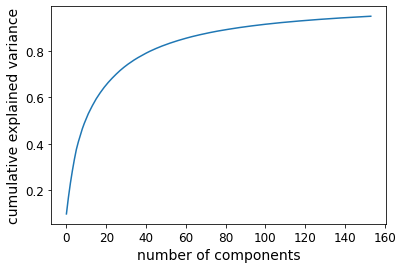

In [28]:
#PCA result
pca_explained_variance = pca.fit(X_train).explained_variance_ratio_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

5. Random Forest Model 3 - PCA Fixed reduced data set 

In [29]:
# Start timer for fit the model
start=datetime.datetime.now()

rf_3 = RandomForestClassifier(n_estimators=154, max_features="sqrt", bootstrap=True, n_jobs=-1, random_state=seed)
rf_3.fit(X_train_pca2, y_train)

end=datetime.datetime.now()
duration4=end-start
print(duration4)

0:02:11.879577


In [30]:
#evaluation of model 3 on test set
y_test_pca2 = cross_val_predict(rf_3, X_test_pca2, y_test)
score_pca2=f1_score(y_test, y_test_pca2, average="macro")
pre_pca2=precision_score(y_test, y_test_pca2, average="macro")
rec_pca2=recall_score(y_test, y_test_pca2, average="macro")
print(score_pca2)
print(pre_pca2)
print(rec_pca2) 



0.9209308513978076
0.9213957106540203
0.9208640916619864


In [31]:
# Store the results in a dictionary
metrics['RF - PCA (Fixed)'] = [score_pca2, duration4, X_train_pca2.shape[1],
                               pre_pca2,rec_pca2]

In [32]:
# Convert metrics dictionary to dataframe for display
results = pd.DataFrame.from_dict(metrics, orient='index')
results.columns = names
#results.sort_values(by=['Time'], inplace=True)
results.to_csv('results.csv')

In [33]:
results

,F1 Score,Time,Number of Variables,Precision Score,Recall Score
RF - No PCA,0.948736,0 days 00:04:36.125338,784,0.949083,0.948564
PCA,NaN,0 days 00:00:12.768435,154,NaN,NaN
RF - PCA on All,0.921204,0 days 00:02:11.083375,154,0.921612,0.921126
PCA-Fixed,NaN,0 days 00:00:11.017798,154,NaN,NaN
RF - PCA (Fixed),0.920931,0 days 00:02:11.879577,154,0.921396,0.920864


6. K-means Clustering

In [34]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))


11493376/11490434 [==============================] - 0s 0us/step
Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


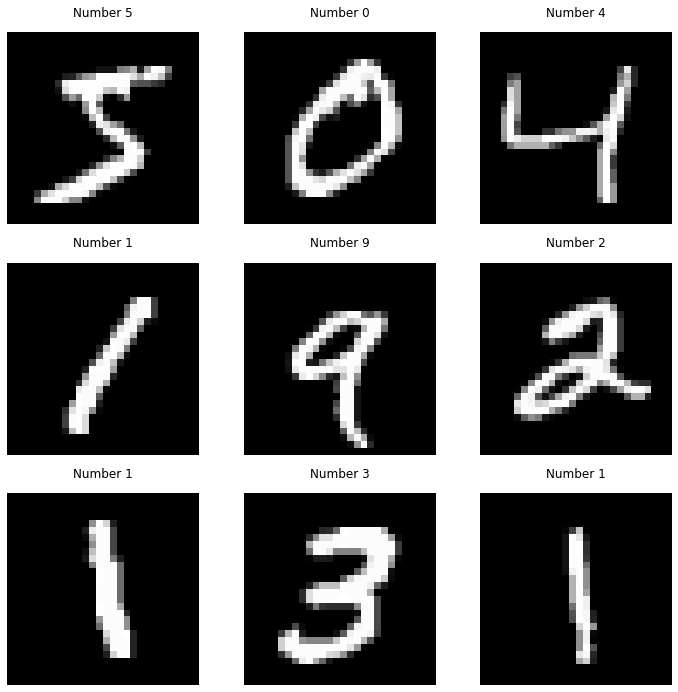

In [43]:
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
fig.show()

In [44]:
# Data Normalization
# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0

In [45]:
# Checking the minimum and maximum values of x_train
print(x_train.min())
print(x_train.max())
# Reshaping input data
X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

0.0
0.003921569


In [38]:
# Checking the shape
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [46]:
from sklearn.cluster import MiniBatchKMeans
total_clusters = len(np.unique(y_test))
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
# Fitting the model to training set
kmeans.fit(X_train)
kmeans.labels_

array([7, 9, 2, ..., 1, 5, 8], dtype=int32)

In [47]:
def retrieve_info(cluster_labels,y_train):

#Associates most probable label with each cluster in KMeans model
 #returns: dictionary of clusters assigned to each label
# Initializing
    reference_labels = {}
# For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [48]:
reference_labels = retrieve_info(kmeans.labels_,y_train)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

In [49]:
# Comparing Predicted values and Actual values
print(number_labels[:20].astype('int'))
print(y_train[:20])

[8 0 9 1 7 2 1 8 1 7 8 1 3 6 1 7 2 1 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [50]:
# Calculating accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(number_labels,y_train))

0.4988166666666667


In [51]:
def calculate_metrics(model,output):
    print('Number of clusters is {}'.format(model.n_clusters))
    print('Inertia : {}'.format(model.inertia_))
    print('Homogeneity :       {}'.format(metrics.homogeneity_score(output,model.labels_)))

In [52]:
from sklearn import metrics
cluster_number = [10,16,36,64,144,256]
for i in cluster_number:
    total_clusters = len(np.unique(y_test))
# Initialize the K-Means model
    kmeans = MiniBatchKMeans(n_clusters = i)
# Fitting the model to training set
    kmeans.fit(X_train)
# Calculating the metrics
 
    calculate_metrics(kmeans,y_train)
# Calculating reference_labels
    reference_labels = retrieve_info(kmeans.labels_,y_train)
# ‘number_labels’ is a list which denotes the number displayed in image
    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
 
        number_labels[i] = reference_labels[kmeans.labels_[i]]
 
    print('Accuracy score : {}'.format(accuracy_score(number_labels,y_train)))
    print('\n')

Number of clusters is 10
Inertia : 36.58589172363281
Homogeneity :       0.4658488367244745
Accuracy score : 0.5419333333333334


Number of clusters is 16
Inertia : 34.20600128173828
Homogeneity :       0.5556738805305491
Accuracy score : 0.6545


Number of clusters is 36
Inertia : 31.870241165161133
Homogeneity :       0.634196208624649
Accuracy score : 0.727


Number of clusters is 64
Inertia : 27.843994140625
Homogeneity :       0.7447752459686278
Accuracy score : 0.83225


Number of clusters is 144
Inertia : 25.117664337158203
Homogeneity :       0.7941975145574485
Accuracy score : 0.8559666666666667


Number of clusters is 256
Inertia : 23.23405647277832
Homogeneity :       0.8428251691196161
Accuracy score : 0.9008166666666667




In [53]:
# Testing model on Testing set
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = 256)
# Fitting the model to testing set
kmeans.fit(X_test)
# Calculating the metrics
calculate_metrics(kmeans,y_test)
# Calculating the reference_labels
reference_labels = retrieve_info(kmeans.labels_,y_test)
# ‘number_labels’ is a list which denotes the number displayed in image
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
 
    number_labels[i] = reference_labels[kmeans.labels_[i]]
 
print('Accuracy score : {}'.format(accuracy_score(number_labels,y_test)))
print('\n')

Number of clusters is 256
Inertia : 3.777113914489746
Homogeneity :       0.8570622713133743
Accuracy score : 0.8984




In [54]:
# Cluster centroids is stored in ‘centroids’
centroids = kmeans.cluster_centers_
centroids.shape

(256, 784)

In [55]:
centroids = centroids.reshape(256,28,28)
centroids = centroids * 255

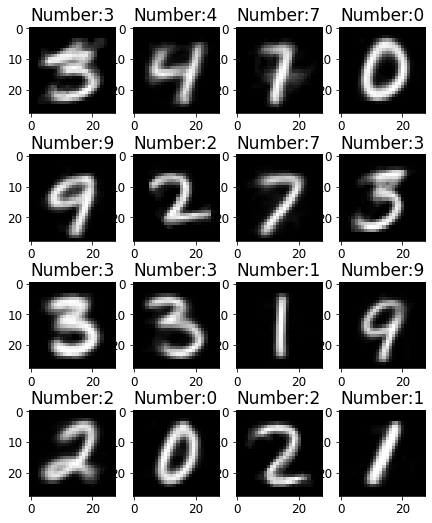

In [56]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.title('Number:{}'.format(reference_labels[i]),fontsize = 17)
    plt.imshow(centroids[i])


# Conclusion

**Background and management problem description**

From a management perspective, the predictive accuracy of models must be weighed against the costs of model development and implementation. In this research, we will develop a classifier using random forest model that may be used to predict which of the 10 digits is being written. In the development process, we will compare the standard random forest classifier with an improved version of model using PCA as preliminary step to reduce the number of principal components. This will help to make the choice that balance the tradeoff between performance and cost of model development and implementation.

**Research design and modeling methods**

There are 70,000 handwritten digits. Each row represents one of these digits. There are 785 columns of data. 784 of them are the integer grey scale values of each pixel in a 28 x 28 pixel square. The first column is the ‘response’ variable, which is the actual value to test the predicted estimate against.

The steps for the analysis are the following:
1) Fit a random forest multi class model using all variables (784)
2) Use Principle Components Analysis (PCA) on the combined training and test set data together to reduce the principal components
3) Use Principle Components Analysis (PCA) on the training set data only to reduce the principal components
4) Fit another random forest model using reduced data set from 2) and 3) respectively
5) Compare the model timing, F1, Precision & Recall Scores
6) Use k-means clustering to group MNIST observations into 1 of 10 categories and then assign labels

**Results and Recommendations** 

Below is a summary of the models that were created in the process of this analysis and their performance comparison. Performance variables include the reduced number of estimators as well as the F1, Precision and Recall scores of test sets.

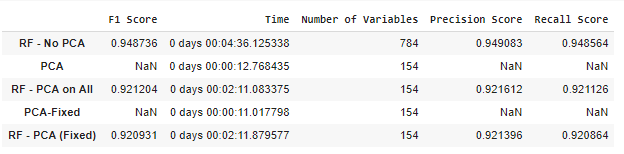

Random Forest Model without PCA has the highest F1 score, as well as precision/recall score. However, the time to fit the model is almost doubled as that of Random Forest Models with PCA.

The number of principal components identified in the PCA is only 154, substantially fewer than the 784 explanatory variables but still explain 95% of the variance in the original data. The time it takes to identify the principal components is around 12.77 seconds.

Compare the RF with PCA on all dataset to the original model, it improves the process with less time. The score is slightly lower than the original RF model with around 0.921 for F1 score, precision score and recall score, 0.02 lower than the original model. 

The version of PCA analysis fixed the design flaw by fitting only on training set spent less time than the PCA analysis on all dataset to identify the principle components, and the score of RF with fixed PCA is slightly lower than RF with PCA on all dataset.

Therefore, the random forest model with PCA on training set should be recommended to the managers. The reason is that the preliminary PCA analysis applied helped develop a random forest model with much fewer explanatory variables, but still will yield more than 0.92 score performance but decrease the process time.

K-mean clustering shows the higher number of clustering is, the higher accuracy score. When the cluster number reaches to 256, the accuracy score on training and testing set are very similar and around 90% which suggests the model is not overfitting the training data and can be generalized well to new data.

